In [3]:
# Notebook Setup
%matplotlib inline

# Libraries
import pandas as pd

# Get Dataset (optional)

In [2]:
# Get current dataset
import urllib.request

with urllib.request.urlopen('https://raw.githubusercontent.com/datasets/covid-19/master/data/countries-aggregated.csv') as f:
    #html = f.read().decode('utf-8')
    df = pd.read_csv(f, encoding = 'utf-8', index_col = [1,0], header = 0)

# Save a cached version    
df.to_pickle("Current.pic")


# Read Dataset

In [4]:
df = pd.read_pickle("Current.pic").sort_index()
df.tail()

Confirmed  Recovered  Deaths
Country  Date                                    
Zimbabwe 2020-07-06        734        197       9
         2020-07-07        787        201       9
         2020-07-08        885        206       9
         2020-07-09        885        206       9
         2020-07-10        942        320      13

# Plot

## 1. Compute metrics of interest

In [5]:
# Daily new infections
df["NewConfirmed"] = df.groupby(level = 0)["Confirmed"].diff()

# Daily new infections (averaged over 7 days to eliminate the weekly testing cycles)
df["weeklyAverage"] = df.groupby(level = 0)["NewConfirmed"].rolling(7, center = True ).mean().values

## 2. Select countries and plotting period

In [11]:
#Find name of countr
[country for country in df.index.levels[0] if "er" in country ]

['Algeria',
 'Azerbaijan',
 'Bosnia and Herzegovina',
 'Cabo Verde',
 'Cameroon',
 'Germany',
 'Liberia',
 'Netherlands',
 'Niger',
 'Nigeria',
 'Peru',
 'Serbia',
 'Sierra Leone',
 'Switzerland',
 'Western Sahara']

In [7]:
#Select
countries = ['Germany','United Kingdom', 'US']
lastXdays = 130

## 3. Plot logarithmic timelines of new infections

/usr/lib/python3/dist-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


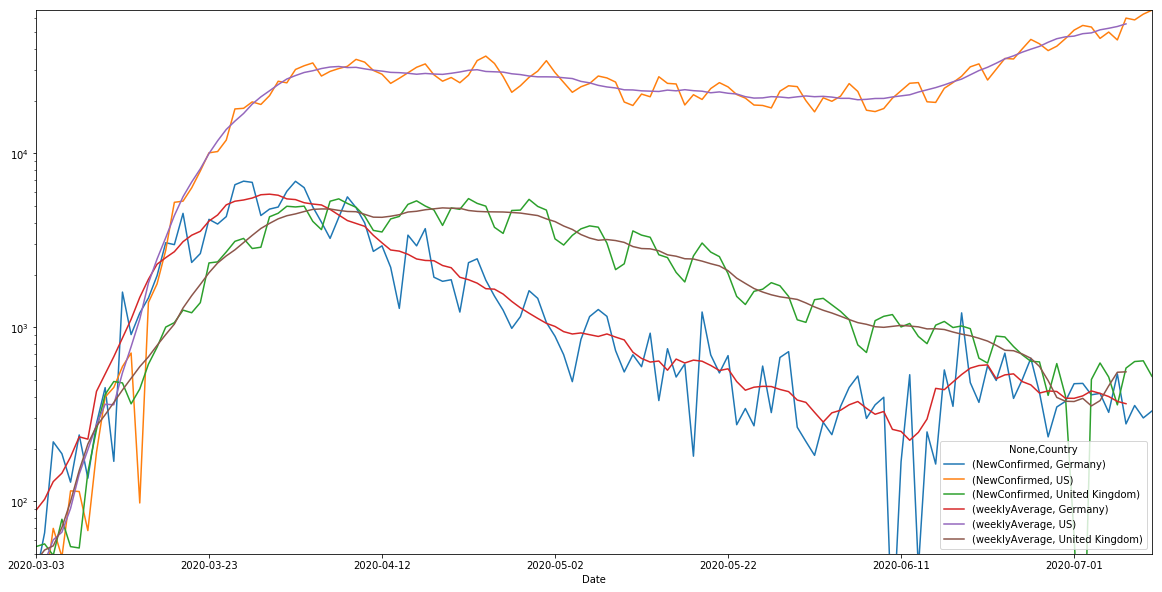

In [8]:
# Filter ...
to_plot = df.loc[
    df.index.get_level_values("Country").isin(countries),
    df.columns.get_level_values(0).isin(['NewConfirmed',"weeklyAverage"])
    ]

# .. and plot 
to_plot.unstack(level=0).iloc[-lastXdays:].dropna(how = 'all')\
.plot(
    figsize = (20,10), 
    logy=True,
    ylim = (50,to_plot.max().max())
);

['US']